# Tutorial 2. Controlling an advanced experiment using MeasurementControl

In this tutorial, we will explore the more advanced features of quantify. Recall our previous definition of a `hard` loop. 


By the end of this tutorial, we will covered

In [2]:
import time
import random

import numpy as np
import xarray as xr
from qcodes import ManualParameter, Parameter
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

In [3]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

# A 1D hard(ware) controlled loop: Resonator Spectroscopy
## Defining a simple model

In this example, we want to tune a Qubit. We expect to find it's resonance somewhere in the low 6GHz range, but manufacturing imperfections makes it impossible to know exactly without inspection. Additionally, we can only observe the Qubit using another readout resonator, which must also be calibrated.

In [9]:
freq = ManualParameter(name='frequency', unit='Hz', label='Frequency')


class MockTransmon:
    """
    Args:
        mode (str): Number of data rows to return, supports '1D' and '2D'
    """
    def __init__(self):
        self.name = 'transmon'
        self.unit = 'A'
        self.label = 'Amplitude'
        self.soft = False
        self.resonance = random.randint(6.0e9, 6.0000001e9)

    def prepare(self, setpoints):
        self.setpoints = setpoints

    def get(self):
        return (self.setpoints[:] == self.resonance).astype(float)


## Running the experiment
Just like our `soft` 1D loop, our complete experiment is expressed in just four lines of code.

Different from the `soft` loop is defining the `soft` property of our `Settable` and `Gettable` to False. The `MeasurementControl` will detect these settings and run in the appropriate`hard` mode.

In [12]:
MC.set_setpars(freq)
MC.set_setpoints(np.arange(6.0e9, 6.0000001e9))
MC.set_getpars(MockTransmon())
dset = MC.run()

 100% completed 	elapsed time: 0.8s 	time left: 0.0s


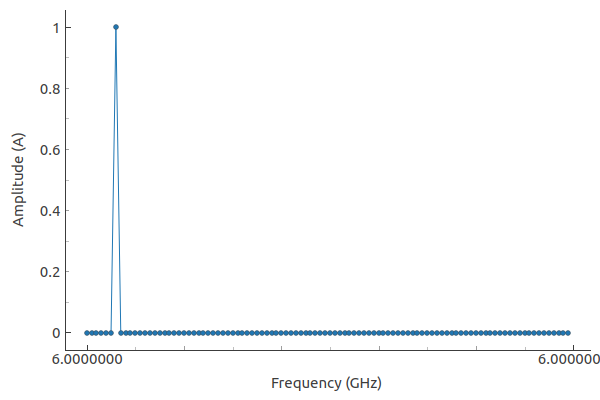

In [13]:
plotmon.main_QtPlot

# Noisy Hardware
Oftentimes we will be working with imperfect hardware. To smooth out this noise, the `MeasurementControl` provides software averaging functionality, where a loop will be run n many times and results averaged together.

## 1. A Noisy Experiment
Here our mock device will add some random noise to each measurement. Our end result isn't quite what we want

In [ ]:
setpoints = np.arange(20.0)
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
d = DummyDetector('2D')
d.noise = 0.8
MC.set_getpars(d)
noisy_dset = MC.run('noisy')

xn_0 = noisy_dset['x0'].values
expected_vals = hardware_mock_values_2D(xn_0)
yn_0 = abs(noisy_dset['y0'].values - expected_vals[0])
yn_1 = abs(noisy_dset['y1'].values - expected_vals[1])

In [ ]:
plotmon.main_QtPlot

## 2. An Averaged Experiment
Here we set the `soft_avg` parameter of the `MeasurementControl` to our desired number of iterations. By averaging the results of 5000 runs of our experiment, we have filtered out the noise in our hardware.

In [ ]:
MC.soft_avg(5000)
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
MC.set_getpars(d)
avg_dset = MC.run('averaged')

yavg_0 = abs(avg_dset['y0'].values - expected_vals[0])
yavg_1 = abs(avg_dset['y1'].values - expected_vals[1])

In [ ]:
plotmon.main_QtPlot

We can additionally verify the average error is much larger in the noisy dataset than in adjusted dataset:

In [ ]:
np.mean(yn_0)

In [ ]:
np.mean(yavg_0)

In [ ]:
# internal set, external get

mock = ManualParameter('m', initial_value=1, unit='M', label='Mock')

def mock_func(none):
    # to also test if the values are set correctly in the sweep
    arr = np.zeros([2, 2])
    arr[0, :] = np.array([mock()])
    arr[1, :] = np.array([mock() + 2])
    return arr

d = DummyDetector(return_dimensions='2D')
d.mock_fn = mock_func
setpoints = np.repeat(np.arange(5.0), 2)

MC.set_setpars(mock)
MC.set_setpoints(setpoints)
MC.set_getpars(d)
dset = MC.run("soft_sweep_hard_det")

In [ ]:
dset

In [ ]:
counter_param = ManualParameter("counter", initial_value=0)

def v_size(setpoints):
    idx = counter_param() % 3
    counter_param(counter_param() + 1)
    if idx == 0:
        return 2 * setpoints[:7]
    elif idx == 1:
        return 2 * setpoints[:4]
    elif idx == 2:
        return 2 * setpoints[:]

setpoints = np.arange(30.0)
d = DummyDetector('1D')
d.mock_fn = v_size
MC.set_setpars(NoneSweep(internal=False))
MC.set_setpoints(setpoints)
MC.set_getpars(d)
dset = MC.run('varying')

In [ ]:
dset

In [ ]:
times = np.linspace(10, 20, 3)
amps = np.linspace(0, 10, 5)

MC.set_setpars([NoneSweep(internal=False, name='t', unit='s', label='Time'), NoneSweep(internal=True, name='amp', unit='V', label='Amplitudes')])
MC.set_setpoints_grid([times, amps])
MC.set_getpars(DummyDetector("2D"))
dset = MC.run('2D Hard')

In [ ]:
dset

In [ ]:
plotmon.main_QtPlot

In [ ]:
plotmon.secondary_QtPlot